In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp /content/gdrive/My\ Drive/py_utils/*.* /content

In [0]:
%tensorflow_version 1.x

In [3]:
!pip install git+https://github.com/rcmalli/keras-vggface.git --quiet

In [0]:
!pip install ipywidgets --quiet

In [0]:
import tensorflow
print(tensorflow.__version__)

1.15.0


In [0]:
import os, sys
import glob
import shutil
import zipfile
import numpy as np
import math
import tarfile
import re
import pickle
import requests
from tqdm import tqdm_notebook as tqdm
from numpy.random import random, permutation
from matplotlib import pyplot as plt
from PIL import Image
import time

In [6]:
from keras import backend as K
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input, Lambda
from keras.utils.data_utils import get_file
from itertools import islice
from matplotlib import rcParams
import random
from PIL import ImageOps, ImageFont, ImageDraw 
import dlib
from skimage import io, transform
import tensorflow as tf
import ipywidgets as widgets
from keras_vggface.vggface import VGGFace
from keras.preprocessing import image
from keras_vggface import utils

Using TensorFlow backend.


In [0]:
from myutils import *

In [0]:
pres_names = "obama, clinton, bush, carter, reagan, nixon, trump"

In [10]:
name_list = pres_names.split(','); 
pres_list = []
for name in name_list:
  pres_list.append(name.strip())


print(pres_list)

['obama', 'clinton', 'bush', 'carter', 'reagan', 'nixon', 'trump']


In [0]:
download_path = "/content/gdrive/My Drive/images/pres_images/"
org_img_path = "/content/gdrive/My Drive/images/original/"
face_img_path = "/content/gdrive/My Drive/images/cropped/"
selected_path = "/content/gdrive/My Drive/images/selected/"

### Downloading and managing images from Google images

In [0]:
!pip install google_images_download --quiet

In [0]:
from google_images_download import google_images_download   #importing the library

response = google_images_download.googleimagesdownload()   #class instantiation

#arguments = {"keywords":pres_names,"limit":5,"print_urls":True}   #creating list of arguments
arguments = {"keywords":"car plates","format":"png","limit":5,"print_urls":True}
paths = response.download(arguments)


Item no.: 1 --> Item name = car plates
Evaluating...
Starting Download...


Unfortunately all 5 could not be downloaded because some images were not downloadable. 0 is all we got for this search filter!

Errors: 0



In [0]:
def rename_move_images(path, dest):
    
    for f in os.listdir(path):
        source_path = path+f+'/'
        if os.path.isdir(path+f):
            for r, d, fil in os.walk(path+f):
                
                dir_list = r.split("/")
                label = dir_list[-1].strip()
                name_dir = dest+label+'/'
                make_path(name_dir)
                for idx in (range(0, len(fil))):
                  if fil[idx].endswith(".jpg"):  
                    fname = label+str(idx)
                    shutil.copyfile(source_path+fil[idx], name_dir +fname+'.jpg')

In [0]:
rename_move_images(download_path, org_img_path)

FileNotFoundError: ignored

### Detecting and cropping images

In [12]:
files_in_path(download_path)

{'bush': 5,
 'carter': 5,
 'clinton': 5,
 'nixon': 5,
 'obama': 5,
 'reagan': 5,
 'trump': 5}

In [0]:
def detect_faces(image):

    # Create a face detector
    face_detector = dlib.get_frontal_face_detector()

    # Run detector and get bounding boxes of the faces on image.
    detected_faces = face_detector(image, 1)
    face_frames = [(x.left(), x.top(),
                    x.right(), x.bottom()) for x in detected_faces]

    return face_frames

In [0]:
def create_cropped_images(original_path, cropped_path):
  for f in os.listdir(original_path):
    print(f)
    name_cropped_dir = cropped_path+f+'/'
    make_path(name_cropped_dir)
    for r, d, fil_list in os.walk(original_path+f):
      for fname in fil_list:
        image = io.imread(original_path+f+'/'+fname)
        detected_faces = detect_faces(image)
        if (len(detected_faces)):
          face = Image.fromarray(image).crop(detected_faces[0])
          face.save(name_cropped_dir+fname)

In [15]:
create_cropped_images(download_path, face_img_path)

nixon
bush
reagan
clinton
obama
carter
trump


### Selecting image pairs

In [0]:
def checkboxes (data):
  names = []
  checkbox_objects = []
  for item in data:
      checkbox_objects.append(widgets.Checkbox(value=False, description=item))
      names.append(item)

  arg_dict = {names[i]: checkbox for i, checkbox in enumerate(checkbox_objects)}

  ui = widgets.VBox(children=checkbox_objects)

  selected_data = []
  def select_data(**kwargs):
      selected_data.clear()
      for key in kwargs:
          if kwargs[key] is True:
              selected_data.append(key)
              
  out = widgets.interactive_output(select_data, arg_dict)
  return ui, selected_data

In [0]:
def show_multiple_images(path):
  fig = plt.figure(figsize=(9, 13))
  fnums = len(os.listdir(path))
  columns = 4
  rows = math.ceil(fnums/columns)
  ax = []
  for r, d, fil_list in os.walk(path):
      for i, fname in enumerate(fil_list):
        img=Image.open(path+'/'+ fname)
        ax.append( fig.add_subplot(rows, columns, i+1) )
        ax[-1].set_title(fname)  # set title
        plt.imshow(img, alpha=1)
      plt.show()
  ui, selected_data = checkboxes (fil_list)
  display(ui)
  return selected_data, r

In [0]:
def move_selected(selection, path):
  fpath = path.replace('cropped', 'selected')
  if os.path.exists(fpath):
    shutil.rmtree(fpath)
  os.makedirs(fpath)
  files = []
  for fname in selection:
    shutil.copyfile(path+'/'+fname, fpath+'/'+fname)
    files.append(fpath+'/'+fname)
  show_multiple_images(fpath)

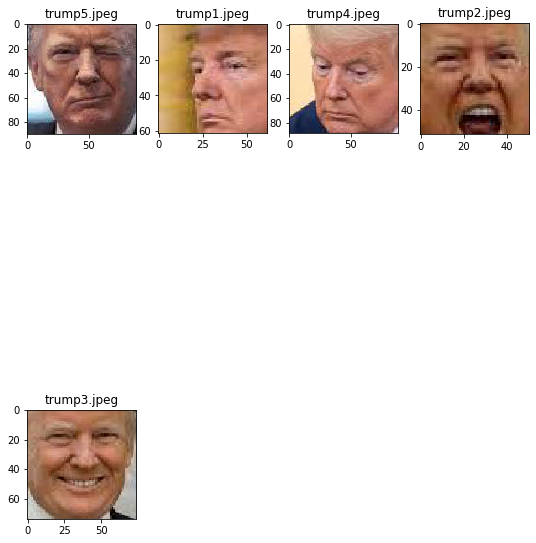

In [19]:
selection, path = show_multiple_images(face_img_path+'trump')

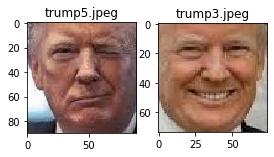

In [20]:
move_selected(selection, path)

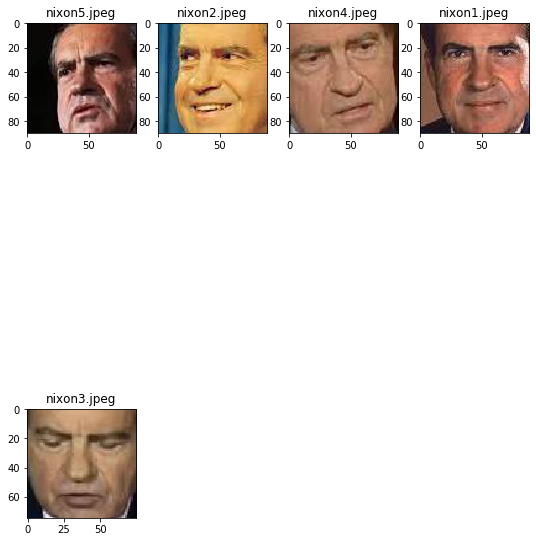

In [21]:
selection, path = show_multiple_images(face_img_path+'nixon')

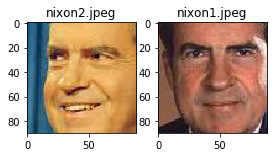

In [22]:
move_selected(selection, path)

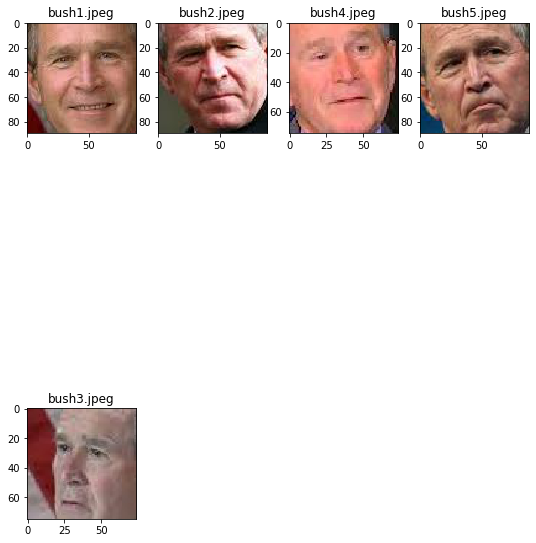

In [23]:
selection, path = show_multiple_images(face_img_path+'bush')

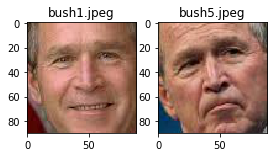

In [24]:
move_selected(selection, path)

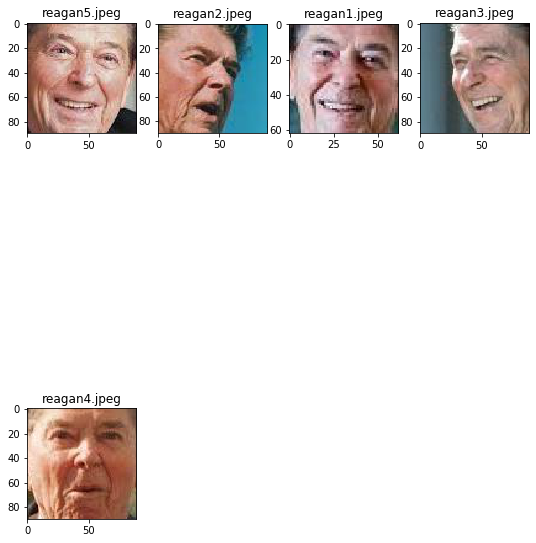

In [25]:
selection, path = show_multiple_images(face_img_path+'reagan')

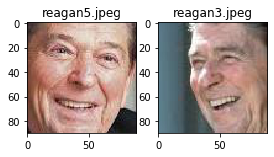

In [26]:
move_selected(selection, path)

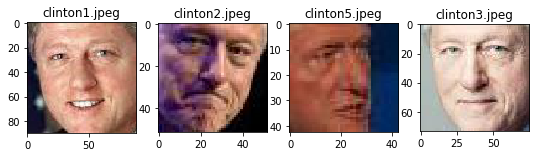

In [27]:
selection, path = show_multiple_images(face_img_path+'clinton')

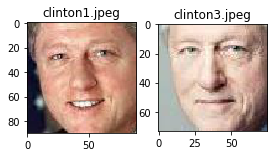

In [28]:
move_selected(selection, path)

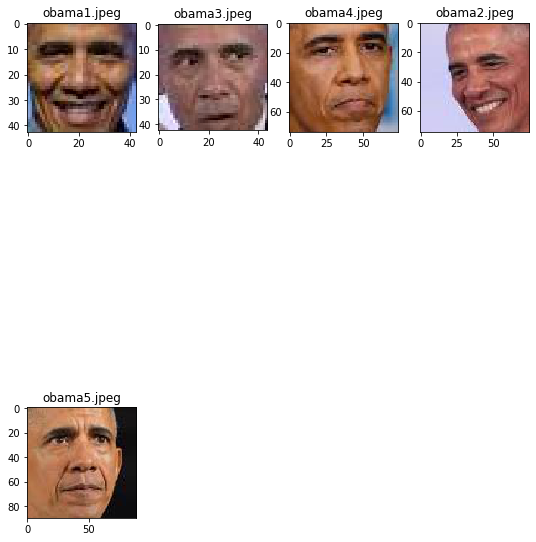

In [29]:
selection, path = show_multiple_images(face_img_path+'obama')

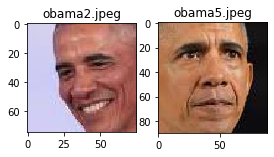

In [30]:
move_selected(selection, path)

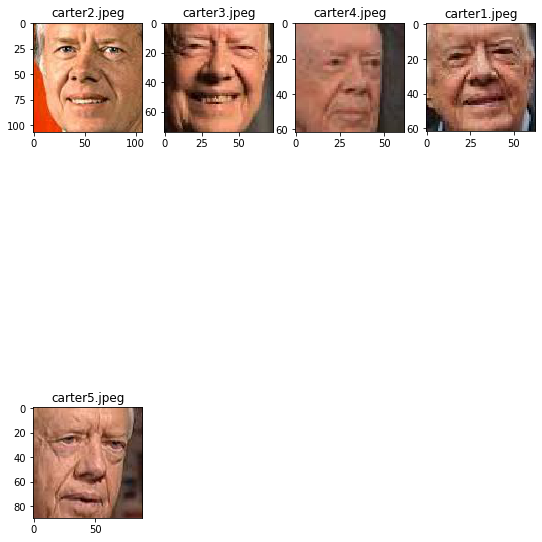

In [31]:
selection, path = show_multiple_images(face_img_path+'carter')

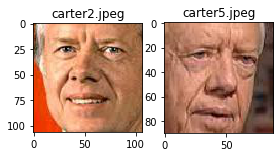

In [32]:
move_selected(selection, path)

In [33]:
import shutil
os.chdir('/content')
shutil.make_archive('presidents', 'zip', '/content/gdrive/My Drive/images/selected')

'/content/presidents.zip'

### Model selection

In [34]:
senet_model = VGGFace(model='senet50', include_top=False, input_shape=(224, 224, 3))














104947712/104944616 [==============================] - 2s 0us/step


In [35]:
senet_model.summary()

Model: "vggface_senet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________

In [0]:
def fr_model():
  last_layer = senet_model.get_layer('avg_pool').output
  X = Flatten(name='flatten')(last_layer)
  X = Dense(128, name='dense_layer')(X)
  # L2 normalization
  out = Lambda(lambda  x: K.l2_normalize(x,axis=1))(X)

  # Create model instance
  model = Model(senet_model.input, out, name='fr_model')
  return model


In [0]:
model = fr_model()

In [38]:
model.summary()

Model: "fr_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________________

### Image encoding

In [0]:
def img_to_encoding(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = utils.preprocess_input(x, version=2)
    embedding = model.predict(x)
    return embedding

In [40]:
dist = {}
for f in os.listdir(selected_path):

  for r, d, fil_list in os.walk(selected_path+f):
    
    dir_list = r.split("/")
    label = dir_list[-1].strip()
    encodes = []
    for fname in fil_list:
      encoding = img_to_encoding(selected_path+label+'/'+fname, model)
      encodes.append(encoding)
    l2_dist = np.linalg.norm(encodes[0]-encodes[1])
    dist[label] = round(l2_dist, 3)
print(dist)


{'trump': 0.555, 'nixon': 0.588, 'bush': 0.648, 'reagan': 0.706, 'clinton': 0.617, 'obama': 0.616, 'carter': 0.555}


In [41]:

col_data = {}
all_flist = []
all_encodes = {}
for f in os.listdir(selected_path):

  for r, d, fil_list in os.walk(selected_path+f):
    for fname in fil_list:
      fname_only = fname.split('.')[0]
      all_flist.append(fname_only)
      print(fname_only)
      enc = img_to_encoding(selected_path+f+'/'+fname, model)
      all_encodes[fname_only] = enc

      

trump5
trump3
nixon2
nixon1
bush1
bush5
reagan5
reagan3
clinton1
clinton3
obama2
obama5
carter2
carter5


In [42]:
print(len(all_encodes['bush5'][0]))

128


In [43]:
for fname in all_flist:
  enc_1 = all_encodes[fname]
  enc_list = []
  for key, val in all_encodes.items():
    l2_dist = np.linalg.norm(val-enc_1)
    enc_list.append(l2_dist)
  col_data[fname] = enc_list

print(col_data)

{'trump5': [0.0, 0.55474657, 1.0810972, 1.1502041, 1.124825, 0.9345648, 0.9587455, 1.0290971, 1.0610635, 0.9358927, 1.1919206, 1.0972362, 0.97073454, 0.8536202], 'trump3': [0.55474657, 0.0, 1.0524772, 1.1590182, 1.1140167, 0.95762086, 1.0137589, 1.1042862, 1.1419075, 1.0837125, 1.2141615, 1.1859347, 0.96688396, 0.8966522], 'nixon2': [1.0810972, 1.0524772, 0.0, 0.58752507, 0.9734472, 0.98727286, 1.1399479, 1.0323488, 1.2082572, 1.2249534, 1.1120768, 1.101865, 1.0360159, 1.0601711], 'nixon1': [1.1502041, 1.1590182, 0.58752507, 0.0, 1.029666, 1.0256288, 1.2016165, 1.1139219, 1.284212, 1.2876126, 1.1193445, 1.1103818, 1.1464592, 1.1374605], 'bush1': [1.124825, 1.1140167, 0.9734472, 1.029666, 0.0, 0.64813733, 0.9643332, 0.95217645, 1.168797, 1.2005088, 1.141028, 1.1684213, 1.114937, 1.1787407], 'bush5': [0.9345648, 0.95762086, 0.98727286, 1.0256288, 0.64813733, 0.0, 0.9097518, 0.98485667, 1.1174, 1.0809829, 1.1793387, 1.1279773, 1.0954963, 1.0873249], 'reagan5': [0.9587455, 1.0137589, 1.139

### Visualization

In [44]:

import pandas as pd
df = pd.DataFrame(col_data,columns=all_flist)
row_names = {}
for i in range(0, len(df)):
  row_names[i] = all_flist[i]
renamed_df = df.rename(row_names)
renamed_df

,trump5,trump3,nixon2,nixon1,bush1,bush5,reagan5,reagan3,clinton1,clinton3,obama2,obama5,carter2,carter5
trump5,0.000000,0.554747,1.081097,1.150204,1.124825,0.934565,0.958745,1.029097,1.061064,0.935893,1.191921,1.097236,0.970735,0.853620
trump3,0.554747,0.000000,1.052477,1.159018,1.114017,0.957621,1.013759,1.104286,1.141907,1.083712,1.214162,1.185935,0.966884,0.896652
nixon2,1.081097,1.052477,0.000000,0.587525,0.973447,0.987273,1.139948,1.032349,1.208257,1.224953,1.112077,1.101865,1.036016,1.060171
nixon1,1.150204,1.159018,0.587525,0.000000,1.029666,1.025629,1.201617,1.113922,1.284212,1.287613,1.119344,1.110382,1.146459,1.137460
bush1,1.124825,1.114017,0.973447,1.029666,0.000000,0.648137,0.964333,0.952176,1.168797,1.200509,1.141028,1.168421,1.114937,1.178741
bush5,0.934565,0.957621,0.987273,1.025629,0.648137,0.000000,0.909752,0.984857,1.117400,1.080983,1.179339,1.127977,1.095496,1.087325
reagan5,0.958745,1.013759,1.139948,1.201617,0.964333,0.909752,0.000000,0.706080,1.058069,1.066217,1.234103,1.156899,1.040187,1.031176
reagan3,1.029097,1.104286,1.032349,1.113922,0.952176,0.984857,0.706080,0.000000,1.053790,1.082534,1.156553,1.123734,1.014934,1.052878
clinton1,1.061064,1.141907,1.208257,1.284212,1.168797,1.117400,1.058069,1.053790,0.000000,0.617312,1.281463,1.234041,1.131043,1.168511
clinton3,0.935893,1.083712,1.224953,1.287613,1.200509,1.080983,1.066217,1.082534,0.617312,0.000000,1.239071,1.174162,1.079962,1.042466


In [45]:
import seaborn as sns

color_map = sns.light_palette("green", as_cmap=True)

styled_df = renamed_df.style.background_gradient(cmap=color_map)
styled_df

,trump5,trump3,nixon2,nixon1,bush1,bush5,reagan5,reagan3,clinton1,clinton3,obama2,obama5,carter2,carter5
trump5,0,0.554747,1.0811,1.1502,1.12483,0.934565,0.958745,1.0291,1.06106,0.935893,1.19192,1.09724,0.970735,0.85362
trump3,0.554747,0,1.05248,1.15902,1.11402,0.957621,1.01376,1.10429,1.14191,1.08371,1.21416,1.18593,0.966884,0.896652
nixon2,1.0811,1.05248,0,0.587525,0.973447,0.987273,1.13995,1.03235,1.20826,1.22495,1.11208,1.10187,1.03602,1.06017
nixon1,1.1502,1.15902,0.587525,0,1.02967,1.02563,1.20162,1.11392,1.28421,1.28761,1.11934,1.11038,1.14646,1.13746
bush1,1.12483,1.11402,0.973447,1.02967,0,0.648137,0.964333,0.952176,1.1688,1.20051,1.14103,1.16842,1.11494,1.17874
bush5,0.934565,0.957621,0.987273,1.02563,0.648137,0,0.909752,0.984857,1.1174,1.08098,1.17934,1.12798,1.0955,1.08732
reagan5,0.958745,1.01376,1.13995,1.20162,0.964333,0.909752,0,0.70608,1.05807,1.06622,1.2341,1.1569,1.04019,1.03118
reagan3,1.0291,1.10429,1.03235,1.11392,0.952176,0.984857,0.70608,0,1.05379,1.08253,1.15655,1.12373,1.01493,1.05288
clinton1,1.06106,1.14191,1.20826,1.28421,1.1688,1.1174,1.05807,1.05379,0,0.617312,1.28146,1.23404,1.13104,1.16851
clinton3,0.935893,1.08371,1.22495,1.28761,1.20051,1.08098,1.06622,1.08253,0.617312,0,1.23907,1.17416,1.07996,1.04247


In [46]:
pres_list

['obama', 'clinton', 'bush', 'carter', 'reagan', 'nixon', 'trump']

### Preparing 2 encoding databases

In [0]:
# separate the encodings for each person into 2 dicts
# dict 1 will be the encoding database in the club
db_encodes = {}
# dict 2 will be encoding done from door camera
camera_encodes = {}
for key, val in all_encodes.items():
  pres_name = ''.join([i for i in key if not i.isdigit()]) 
  if not pres_name in db_encodes:
    db_encodes[pres_name] = val
  else:
    camera_encodes[pres_name] = val

In [0]:
same_dist = {}
for name in pres_list:
  enc_db = db_encodes[name]
  enc_camera = camera_encodes[name]
  l2_dist = np.linalg.norm(enc_db-enc_camera)
  same_dist[name] = l2_dist


In [49]:
print(same_dist)

{'obama': 0.61625314, 'clinton': 0.61731166, 'bush': 0.64813733, 'carter': 0.5550111, 'reagan': 0.70607954, 'nixon': 0.58752507, 'trump': 0.55474657}


In [50]:
print(camera_encodes)

{'trump': array([[ 0.00310324, -0.01879944, -0.03653776, -0.04720161,  0.08657178,
         0.10400461, -0.05371963,  0.00408833, -0.01462937,  0.12690939,
         0.00683062, -0.00516754,  0.16061449,  0.08075096,  0.04292947,
         0.0200295 ,  0.09203715,  0.02790662, -0.10824493,  0.06787033,
        -0.00496751,  0.20154314,  0.02410934, -0.09701645,  0.00600961,
        -0.16248576, -0.07293127, -0.06237828,  0.02996842,  0.0089056 ,
        -0.0350518 , -0.19461212, -0.06092499, -0.02104789, -0.07651287,
         0.05748023, -0.0574558 , -0.01762869, -0.18765548, -0.10650551,
        -0.06411885,  0.13286293, -0.08500762,  0.05449266, -0.11984712,
        -0.03622177, -0.09556695,  0.05202626,  0.0069752 , -0.10756622,
         0.03336786,  0.02021911,  0.00953528, -0.07935861,  0.00642775,
        -0.05692926,  0.05170623, -0.05876425, -0.05090329, -0.09840459,
        -0.0066982 ,  0.04648859, -0.0659954 ,  0.00454242,  0.00075097,
        -0.0063089 , -0.1084288 ,  0.0358

In [0]:
del db_encodes['nixon'] 

President Nixon walks in. Check if he is a club member and print a mesage "You are not allowed in"

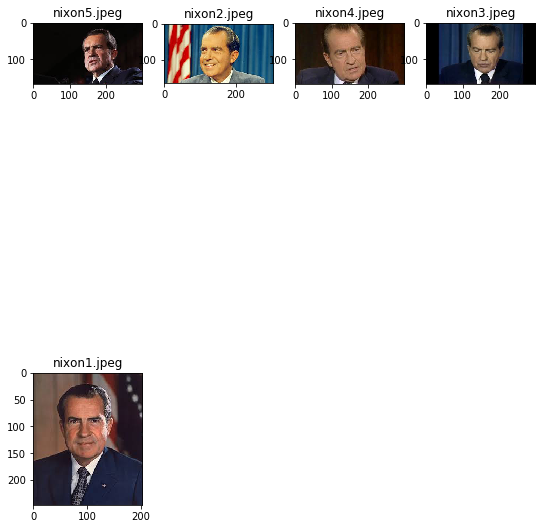

In [52]:
#Select photo from camera download
selection, path = show_multiple_images(download_path+'nixon')

In [0]:
# Define the function to detect, crop face from the selected camera photo and save to camera path
def detect_from_camera(selection, path, camera_path): 
  if os.path.exists(camera_path):
    shutil.rmtree(camera_path)
  os.makedirs(camera_path)
  files = []
  for fname in selection:
    image = io.imread(path + '/' +fname)
    detected_faces = detect_faces(image)
    if (len(detected_faces)):
      face = Image.fromarray(image).crop(detected_faces[0])
      face.save(camera_path + '/' +fname)
      files.append(camera_path+'/'+fname)
    else:
      print("Can not detect any face from the selected image")
  show_multiple_images(camera_path)

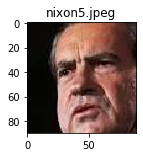

In [54]:
#Crop and Save the selected image 
camera_path = "/content/gdrive/My Drive/images/camera"
detect_from_camera(selection, path, camera_path)

In [55]:
#Encoding the selected image
person = img_to_encoding(camera_path +'/' + selection[0], model)

same_dist_camera = {}                         #door camera database encoding
for name in camera_encodes.keys():
  enc_camera = camera_encodes[name]
  l2_dist = np.linalg.norm(person-enc_camera)
  same_dist_camera[name] = l2_dist

same_dist_db = {}                             #club database encoding 
for name in db_encodes.keys():
  enc_db = db_encodes[name]
  l2_dist = np.linalg.norm(person-enc_db)
  same_dist_db[name] = l2_dist

min_dist = min(same_dist_camera.values())       #distance for camera database value
name = [key for key in same_dist_camera if same_dist_camera[key] == min_dist]
if min_dist > 0.8:
  print("You are not a President")
else:                                           #distance for club database value
  min_dist2 = min(same_dist_db.values()) 
  name2 = [key for key in same_dist_db if same_dist_db[key] == min_dist2]
  if name2 == name:
    print("Welcome President {}!".format(name[0]))
  else:
    print("You are not allowed in!")

You are not allowed in!


President Clinton walks in. Find out who he is and print a message "Welcome President Clinton"

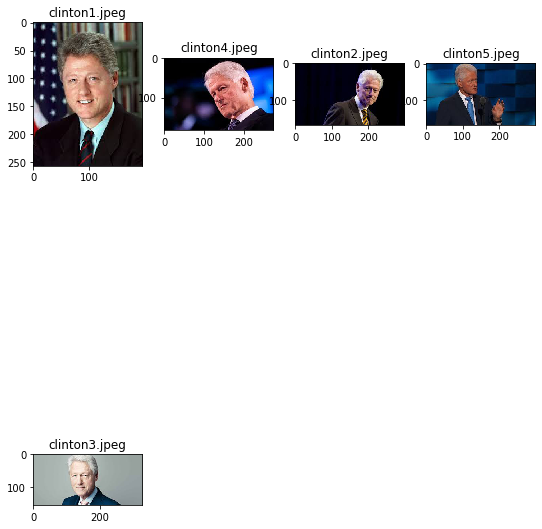

In [56]:
#Select photo from camera download
selection, path = show_multiple_images(download_path+'clinton')

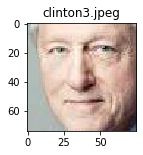

In [60]:
#Crop and Save the selected image to camera path
camera_path = "/content/gdrive/My Drive/images/camera"
detect_from_camera(selection, path, camera_path)

In [61]:
#Encoding the selected image
person = img_to_encoding(camera_path +'/' + selection[0], model)

same_dist_camera = {}                         #door camera database encoding
for name in camera_encodes.keys():
  enc_camera = camera_encodes[name]
  l2_dist = np.linalg.norm(person-enc_camera)
  same_dist_camera[name] = l2_dist

same_dist_db = {}                             #club database encoding 
for name in db_encodes.keys():
  enc_db = db_encodes[name]
  l2_dist = np.linalg.norm(person-enc_db)
  same_dist_db[name] = l2_dist

min_dist = min(same_dist_camera.values())       #distance for camera database value
name = [key for key in same_dist_camera if same_dist_camera[key] == min_dist]
if min_dist > 0.8:
  print("You are not a President")
else:                                           #distance for club database value
  min_dist2 = min(same_dist_db.values()) 
  name2 = [key for key in same_dist_db if same_dist_db[key] == min_dist2]
  if name2 == name:
    print("Welcome President {}!".format(name[0]))
  else:
    print("You are not allowed in!")

Welcome President clinton!
